In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import dataGathandMan
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
from itertools import product
import pickle

In [11]:
# Get all image paths in the folder
folder_path = "/home/tague/classes/aiclass/RawData/"
image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tiff')]
square_size = 64

# Randomly sample patches
random_all_patches = dataGathandMan.random_sample_patches(image_paths, square_size)
# Ensure the data shape is correct
print(f"random_all_patches shape: {random_all_patches.shape}")

all_patches shape: (2048, 64, 64, 12)
random_all_patches shape: (2048, 64, 64, 12)


In [30]:
# Reshape the data for clustering
reshaped_patches = random_all_patches.reshape(2048 * square_size**2, 12)
print(reshaped_patches.shape)

(8388608, 12)


In [13]:
# SOM hyperparameters

# set som lattice dimensions (i.e., number of nodes)
som_grid_rows = 3
som_grid_columns = 3

# number of weights per node
input_length = 12

# Spread of the neighborhood function, needs to be adequate to the dimensions
# of the map. (rows/columns minus 1 usually)
sigma = 2.0

# initial learning rate (at the iteration t we have learning_rate(t) =
# learning_rate / (1 + t/T) where T is #num_iteration/2)
learning_rate = 0.5

# Function that reduces learning_rate at each iteration
# Possible values: 'inverse_decay_to_zero', 'linear_decay_to_zero', 'asymptotic_decay'
# 'inverse_decay_to_zero' == > C = max_iter / 100.0; where, learning_rate * C / (C + t)
# 'linear_decay_to_zero' == > learning_rate * (1 - t / max_iter)
# 'asymptotic_decay' == > dynamic_parameter / (1 + t / (max_iter / 2))
# ^^Decay function of the learning process and sigma that decays these values asymptotically to 1/3 of their original values.
decay_function='inverse_decay_to_zero'

# Function that reduces sigma at each iteration.
# Possible values: 'inverse_decay_to_one', 'linear_decay_to_one', 'asymptotic_decay'
# 'inverse_decay_to_one' == > C = (sigma - 1) / max_iter; where, sigma / (1 + (t * C))
# 'linear_decay_to_one' == > sigma + (t * (1 - sigma) / max_iter)
sigma_decay_function='inverse_decay_to_one'

# Function that weights the neighborhood of a position in the map.
# Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle',
# which takes in sigma.
neighborhood_function = 'gaussian'

# Topology of the map; Possible values: 'rectangular', 'hexagonal'
topology = 'rectangular'

# Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
activation_distance = 'euclidean'

# Random seed to use for reproducibility. Using 1.
random_seed = 1

In [14]:
# lets create our som object with preset hyperparameters
som = MiniSom(
            som_grid_rows,
            som_grid_columns,
            input_length,
            sigma,
            learning_rate,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed,
            sigma_decay_function
            )

In [6]:
som

In [32]:
# some training hyperparameters
epochs = 10000
random_order = True
verbose = True

# let's initialize the weights
som.random_weights_init(reshaped_patches)
# now train!
som.train(
    reshaped_patches,
    epochs,
    random_order,
    verbose
    )

# saving the som in the file som.p
with open('som.p', 'wb') as outfile:
    pickle.dump(som, outfile)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 131.95389684728093


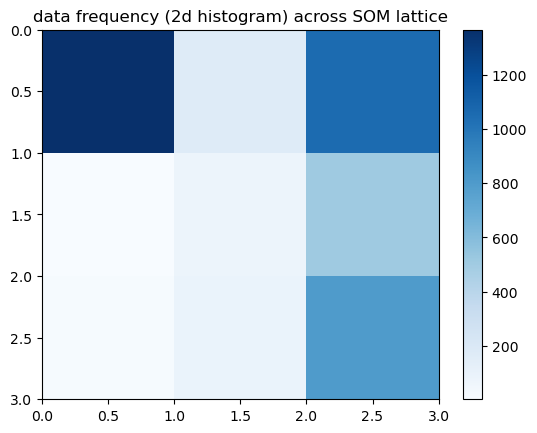

In [25]:
plt.figure()
frequencies = som.activation_response(reshaped_patches)
plt.pcolormesh(frequencies, cmap='Blues')
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
plt.show()


In [26]:
# grabbing indices from SOM

# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_grid_rows), range(som_grid_columns))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(reshaped_patches):
    winmap[som.winner(x)].append(i)

som_keys = list(winmap.keys())
print(f"Number of SOM nodes: {len(som_keys)}")

Number of SOM nodes: 9


In [28]:
winmap[(0,0)]

[30,
 40,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 59,
 60,
 61,
 62,
 63,
 70,
 71,
 72,
 73,
 80,
 81,
 82,
 83,
 90,
 91,
 92,
 93]

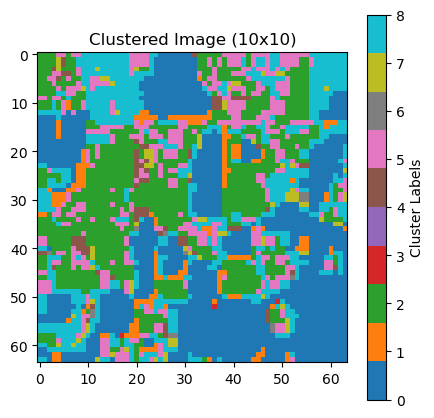

In [27]:
# Define cluster_dict from winmap
cluster_dict = {key: value for key, value in winmap.items() if value}

# Define height and width based on square_size
height, width = square_size, square_size

# Initialize a 1D array for cluster labels, default to -1 (unlabeled)
flattened_labels = np.full(square_size**2, -1)

# Assign each pixel to its corresponding cluster index
for cluster_idx, (cluster_name, pixel_indices) in enumerate(cluster_dict.items()):
    flattened_labels[pixel_indices] = cluster_idx  # Assign a unique index to each cluster

# Reshape to 2D
image_clusters = flattened_labels.reshape(height, width)

# Plot the clustered image
plt.figure(figsize=(5, 5))
plt.imshow(image_clusters, cmap="tab10", interpolation="nearest")
plt.colorbar(ticks=range(len(cluster_dict)), label="Cluster Labels")
plt.title("Clustered Image (10x10)")
plt.show()